In [0]:
import os
import string
from builtins import range,input
import sys
import numpy as np 
import tensorflow
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam,SGD


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
MAX_SEQUENCE_LENGTH=100
MAX_VOCAB_SIZE=3000
EMBEDDING_DIM=50
VALIDATION_SPLIT=0.2
BATCH_SIZE=64
EPOCHS=100
LATENT_DIM=256
NUM_SAMPLES=10000
MAX_NUM_WORDS=20000

In [0]:
input_texts=[]
target_texts=[]
target_texts_inputs=[]

In [0]:
t=0
for line in open('/content/drive/My Drive/word2vec/hin.txt'):
    t+=1
    if t> NUM_SAMPLES:
        break
    if '\t' not in line:
        continue
    input_text,translation=line.split('\t')[:2]
    target_text=translation+' <eos>'
    target_text_input='<sos> '+translation

    input_texts.append(input_text)
    target_texts.append(target_text)
    target_texts_inputs.append(target_text_input)


print('num of samples:',len(input_texts))

num of samples: 2778


In [0]:
input_texts[1],target_texts[1],target_texts_inputs[1]

('Help!', 'बचाओ! <eos>', '<sos> बचाओ!')

In [0]:
#tokenizing inputs
tokenizer_inputs=Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer_inputs.fit_on_texts(input_texts)
input_sequences=tokenizer_inputs.texts_to_sequences(input_texts)

word2idx_inputs=tokenizer_inputs.word_index

In [0]:
len(word2idx_inputs)

2375

In [0]:
max_len_input=max(len(s) for s in input_sequences)

In [0]:
max_len_input

22

In [0]:
tokenizer_outputs=Tokenizer(num_words=MAX_NUM_WORDS,filters='')

In [0]:
tokenizer_outputs.fit_on_texts(target_texts+target_texts_inputs)
target_sequences=tokenizer_outputs.texts_to_sequences(target_texts)
target_sequences_inputs=tokenizer_outputs.texts_to_sequences(target_texts_inputs)

In [0]:
word2idx_outputs=tokenizer_outputs.word_index

In [0]:
num_words_output=len(word2idx_outputs)+1
max_len_target=max(len(s) for s in target_sequences)

In [0]:
encoder_inputs=pad_sequences(input_sequences,maxlen=max_len_input)
print(encoder_inputs.shape,encoder_inputs[0])

(2778, 22) [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0 1264]


In [0]:
decoder_inputs=pad_sequences(target_sequences_inputs,maxlen=max_len_target,padding='post')

In [0]:
decoder_targets=pad_sequences(target_sequences,maxlen=max_len_target,padding='post')

In [0]:
word2vec={}
with open('/content/drive/My Drive/word2vec/glove.6B.50d.txt') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vec=np.asarray(values[1:],dtype='float32')
        word2vec[word]=vec


In [0]:
num_words=min(MAX_NUM_WORDS,len(word2idx_inputs)+1)
embedding_matrix=np.zeros((num_words,EMBEDDING_DIM))
for word,i in word2idx_inputs.items():
    if i<MAX_NUM_WORDS:
        embedding_vector=word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i]=embedding_vector

In [0]:
embedding_layer=Embedding(num_words,EMBEDDING_DIM,weights=[embedding_matrix],input_length=max_len_input)

In [0]:
decoder_targets_one_hot=np.zeros((
    len(input_texts),max_len_target,num_words_output),dtype='float32'

)

In [0]:
for i,d in enumerate(decoder_targets):
    for t,word in enumerate(d):
        decoder_targets_one_hot[i,t,word]=1
        

In [0]:
#model

encoder_inputs_placeholder=Input(shape=(max_len_input,))
x=embedding_layer(encoder_inputs_placeholder)
encoder=LSTM(LATENT_DIM,return_state=True,dropout=0.5)
encoder_outputs,h,c=encoder(x)


encoder_states=[h,c]
decoder_inputs_placeholder=Input(shape=(max_len_target,))
decoder_embedding=Embedding(num_words_output,LATENT_DIM)
decoder_inputs_x=decoder_embedding(decoder_inputs_placeholder)
decoder_lstm=LSTM(LATENT_DIM,return_state=True,return_sequences=True,dropout=0.5)
decoder_outputs,_,_=decoder_lstm(decoder_inputs_x,
                                 initial_state=encoder_states)



In [0]:
decoder_dense=Dense(num_words_output,activation='softmax')
decoder_outputs=decoder_dense(decoder_outputs)

In [0]:
model=Model([encoder_inputs_placeholder,decoder_inputs_placeholder],decoder_outputs)

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
r=model.fit([encoder_inputs,decoder_inputs],
            decoder_targets_one_hot,
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_split=0.2)

Epoch 1/100
35/35 [==============================] - 3s 92ms/step - loss: 2.4383 - accuracy: 0.7139 - val_loss: 2.8817 - val_accuracy: 0.5847
Epoch 2/100
35/35 [==============================] - 2s 63ms/step - loss: 1.5966 - accuracy: 0.7515 - val_loss: 2.6974 - val_accuracy: 0.6054
Epoch 3/100
35/35 [==============================] - 2s 63ms/step - loss: 1.4836 - accuracy: 0.7716 - val_loss: 2.6672 - val_accuracy: 0.6259
Epoch 4/100
35/35 [==============================] - 2s 63ms/step - loss: 1.4255 - accuracy: 0.7759 - val_loss: 2.6799 - val_accuracy: 0.6272
Epoch 5/100
35/35 [==============================] - 2s 61ms/step - loss: 1.3806 - accuracy: 0.7798 - val_loss: 2.7042 - val_accuracy: 0.6324
Epoch 6/100
35/35 [==============================] - 2s 60ms/step - loss: 1.3404 - accuracy: 0.7839 - val_loss: 2.6646 - val_accuracy: 0.6372
Epoch 7/100
35/35 [==============================] - 2s 61ms/step - loss: 1.3049 - accuracy: 0.7875 - val_loss: 2.6341 - val_accuracy: 0.6401
Epoch 

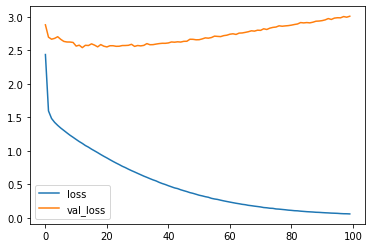

In [0]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

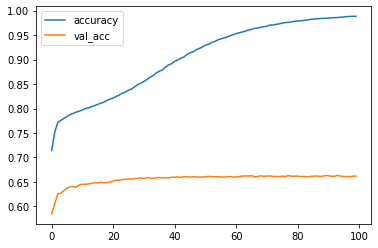

In [0]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_acc')
plt.legend()
plt.show()

In [0]:
encoder_model=Model(encoder_inputs_placeholder,encoder_states)

decoder_state_input_h=Input(shape=(LATENT_DIM,))
decoder_state_input_c=Input(shape=(LATENT_DIM,))
decoder_states_inputs=[decoder_state_input_h,decoder_state_input_c]

decoder_inputs_single=Input(shape=(1,))
decoder_inputs_single_x=decoder_embedding(decoder_inputs_single)

decoder_outputs,h,c=decoder_lstm(decoder_inputs_single_x,initial_state=decoder_states_inputs)


In [0]:
decoder_states=[h,c]
decoder_outputs=decoder_dense(decoder_outputs)


In [0]:
decoder_model=Model([decoder_inputs_single]+decoder_states_inputs,[decoder_outputs]+decoder_states)

In [0]:
idx2word_eng={v:k for k,v in word2idx_inputs.items()}
idx2word_trans={v:k for k,v in word2idx_outputs.items()}


In [0]:
def decode_sequence(input_seq):
    states_value=encoder_model.predict(input_seq)
    target_seq=np.zeros((1,1))
    target_seq[0,0]=word2idx_outputs['<sos>']

    eos=word2idx_outputs['<eos>']

    output_sentence=[]
    for _ in range(max_len_target):
        output_tokens,h,c=decoder_model.predict([target_seq]+states_value)


        idx=np.argmax(output_tokens[0,0,:])

        if eos==idx:
            break
        word=''
        if idx>0:
            word=idx2word_trans[idx]
            output_sentence.append(word)

        target_seq[0,0]=idx

        states_value=[h,c]

    return ' '.join(output_sentence)



In [0]:
while True:
    i=np.random.choice(len(input_texts))
    input_seq=encoder_inputs[i:i+1]
    translation=decode_sequence(input_seq)
    print('-')
    print('input:',input_texts[i])
    print('translation:',translation)

    ans=input("continue? [y/n]")
    if ans and ans.lower().startswith('n'):
        break


-
input: Almost all the leaves have fallen.
translation: लगभग सारी-की-सारी पत्तियाँ गिर चुकीं हैं।
continue? [y/n]y
-
input: This is your key.
translation: यह आपकी चाबी है।
continue? [y/n]y
-
input: Read it again.
translation: इसे दोबारा पढ़ें।
continue? [y/n]y
-
input: The girl who works at the bakery is cute.
translation: उस लड़के के जेब में एक सेव है।
continue? [y/n]y
-
input: Few people will admit their faults.
translation: बहुत कम लोग अपनी गलतियों को मानते हैं।
continue? [y/n]y
-
input: A good idea suddenly struck her.
translation: अचानक उसे एक अच्छा आइडिया आया।
continue? [y/n]y
-
input: "What time is it?" "It's 3:20."
translation: "अभी कितने बजे हैं?" "तीन बीस बजे हैं"
continue? [y/n]y
-
input: The animals in the forest died off.
translation: जंगल के जानवर मर गए।
continue? [y/n]y
-
input: I'll be staying here for three months.
translation: मैं यहाँ तीन महीनों के लिए रहूँगा।
continue? [y/n]n


In [0]:
#custom function
def lets_translate():
    
    while True:

        my_sentence=[]
        line=input('give a sentence to translate into hindi:')
        my_sentence.append(line)
        ip_seq=tokenizer_inputs.texts_to_sequences(my_sentence)
        encoder_ip_inputs=pad_sequences(ip_seq,maxlen=max_len_input)
        smpl=encoder_ip_inputs[0:1]  #so that predict function recieves proper size
        tr=decode_sequence(smpl)
        print('translation: '+tr)
        print('--')
        ch=input('continue?[y/n]')
        if ch.lower().startswith('n'):
            break





In [0]:
lets_translate()